# Analizando endereços

Nesse notebook vamos coletar os de alguns endereços diferentes, fazer a prova de conceito do mapa e analizar o preço de cada endereço

In [1]:
# Para conseguir ler os módulos do projeto
import sys
sys.path.append("../")

In [1]:
from src.database.firebase_manager import get_firebase_data, connect_to_firebase
import seaborn as sns
import pandas as pd
import numpy as np
import folium
import re

In [6]:
connect_to_firebase()

In [61]:

enderecos = ["Perdizes, São Paulo", "Consolação, São Paulo", "Liberdade, São Paulo"]

lista_df = []
for endereco in enderecos:
    data = get_firebase_data(endereco)
    df_endereco = pd.DataFrame(data)
    df_endereco["label"] = endereco.replace(", ", "")
    lista_df.append(df_endereco)
    
df = pd.concat(lista_df, ignore_index=True)
df.head(3)

,banheiros,distance,endereço,img1,lat,link,lon,preço,quartos,site,texto,área,vagas,valor_de_condominio,label
0,3,32.722590,"05014-000, Perdizes, São Paulo, Estado de São ...",https://img-us-1.trovit.com/img1br/y1o1I1Gs1u1...,-23.532482,https://rd.clk.thribee.com/id.y1o1I1Gs1u1qO/or...,-46.666471,10800,3,trovit,"Apto, Perdizes, 3 Quarto, 270 m2 - São Paulo\n...",270,NaN,NaN,PerdizesSão Paulo
1,3,32.724473,"05015-000, Perdizes, São Paulo, Estado de São ...",https://img-us-1.trovit.com/img1br/1X1YV1jdAa1...,-23.531820,https://rd.clk.thribee.com/id.1X1YV1jdAa11/ori...,-46.668472,2640,3,trovit,"Apto, Perdizes, 3 Quarto, 131 m2 - São Paulo\n...",131,NaN,NaN,PerdizesSão Paulo
2,2,32.724473,"05015-000, Perdizes, São Paulo, Estado de São ...",https://img-us-1.trovit.com/img1br/1Q1gYM1w1h1...,-23.531820,https://rd.clk.thribee.com/id.1Q1gYM1w1h1j1y/o...,-46.668472,5500,3,trovit,"Casa, Perdizes, 3 Quarto, 100 m2 - São Paulo\n...",100,NaN,NaN,PerdizesSão Paulo


## Limpando os dados

In [62]:
# valor_de_condominio não pode ter str para possibilitar contas
df.valor_de_condominio.fillna(0, inplace=True)
df.fillna("Não especificado", inplace=True)

def int2float(valor):
    if isinstance(valor, float):
            valor = int(valor)
    return valor
df.vagas= df.vagas.apply(int2float)
df.head(3)

,banheiros,distance,endereço,img1,lat,link,lon,preço,quartos,site,texto,área,vagas,valor_de_condominio,label
0,3,32.722590,"05014-000, Perdizes, São Paulo, Estado de São ...",https://img-us-1.trovit.com/img1br/y1o1I1Gs1u1...,-23.532482,https://rd.clk.thribee.com/id.y1o1I1Gs1u1qO/or...,-46.666471,10800,3,trovit,"Apto, Perdizes, 3 Quarto, 270 m2 - São Paulo\n...",270,Não especificado,0.0,PerdizesSão Paulo
1,3,32.724473,"05015-000, Perdizes, São Paulo, Estado de São ...",https://img-us-1.trovit.com/img1br/1X1YV1jdAa1...,-23.531820,https://rd.clk.thribee.com/id.1X1YV1jdAa11/ori...,-46.668472,2640,3,trovit,"Apto, Perdizes, 3 Quarto, 131 m2 - São Paulo\n...",131,Não especificado,0.0,PerdizesSão Paulo
2,2,32.724473,"05015-000, Perdizes, São Paulo, Estado de São ...",https://img-us-1.trovit.com/img1br/1Q1gYM1w1h1...,-23.531820,https://rd.clk.thribee.com/id.1Q1gYM1w1h1j1y/o...,-46.668472,5500,3,trovit,"Casa, Perdizes, 3 Quarto, 100 m2 - São Paulo\n...",100,Não especificado,0.0,PerdizesSão Paulo


## Criando o mapa

In [63]:
first_sixth = np.quantile(df.preço, 1/6)
last_sixth = np.quantile(df.preço, 5/6)

# Criando nosso mapa
m = folium.Map(location=[-23.5558, -46.6396], zoom_start=13)

ziped_data = zip(
    df.lat, df.lon, df['preço'], 
    df['quartos'], df['banheiros'], 
    df['vagas'], df['área'], df.link, df.img1
)


for lat, lon,preco, n_quartos, n_banheiros, n_vagas, area, link, img in ziped_data:
    html = f'''
    <img src="{img}" alt="Foto anúncio" style="width:100%;">
    <table id="vertical-1" class="centerTable">
      <tr>
        <th>Aluguel</th>
        <td>R$ {preco},00</td>
      </tr>
      <tr>
        <th>Quartos</th>
        <td>{n_quartos}</td>
      </tr>
      <tr>
        <th>Banheiros</th>
        <td>{n_banheiros}</td>
      </tr>
      <tr>
        <th>Vagas</th>
        <td>{n_vagas}</td>
      </tr>
      <tr>
        <th>Área</th>
        <td>{area} m²</td>
      </tr>
    </table>
    <div style="text-align:center">
        <a href="{link}">link</a>
    </div>'''
    iframe = folium.IFrame(html,
                       width=250,
                       height=400)
    popup = folium.Popup(iframe)
    if preco <= first_sixth:
        color="green"
    elif preco < last_sixth:
        color="orange"
    else:
        color="red"
    folium.Marker(
        location=[lat, lon],
        popup=popup,
        icon=folium.Icon(icon="building", prefix="fa", color=color),
    ).add_to(m)

In [64]:
m

## Estatisticas sobre os imóveis

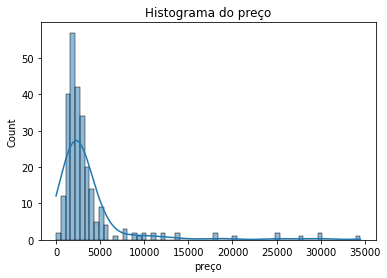

In [65]:
sns.histplot(df.preço, kde=True).set_title("Histograma do preço");

Percebemos que alguns imóveis estavam com o preço muito alto, perto dos 300 mil, investigando esses anúncios vimos que alguns sites possuem edificios por completo para a locação (escritórios). Como o nosso público alvo são estudandes optamos por remover esses outliers 

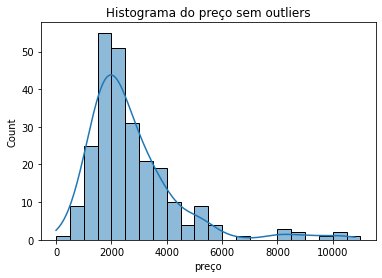

In [66]:
sns.histplot(
    df[df.preço < np.quantile(df.preço, 0.95)].preço, binwidth=500, kde=True
).set_title("Histograma do preço sem outliers");

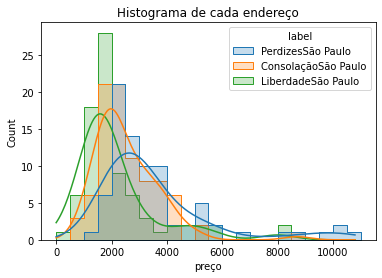

In [73]:
sns.histplot(
    data = df[df.preço < np.quantile(df.preço, 0.95)], x="preço", hue="label", binwidth=500, kde=True, element="step"
).set_title("Preço de cada endereço");

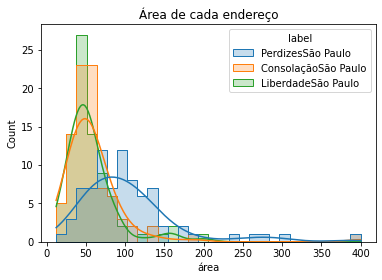

In [75]:
sns.histplot(
    data=df[df.preço < np.quantile(df.preço, 0.95)], x="área", hue="label", kde=True, element="step"
).set_title("Área de cada endereço");